In [32]:
import numpy as np
import random
import os, errno
import sys
from tqdm import trange
from copy import deepcopy

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

import pandas as pd
import math

In [33]:
data_folder = "C:\\Users\\spars\\Documents\\Master\\JHU\TML\\HomePriceBeastNew\\"

In [34]:
with open(f"{data_folder}all_model_data_sale_model.npy", 'rb') as f:
    # Format of input x: (J, batch_size, num_features(k)), y: (H, batch_size, 1)
    X_train = np.load(f, allow_pickle=True)
    y_train = np.load(f, allow_pickle=True)
    X_test = np.load(f, allow_pickle=True)
    y_test = np.load(f, allow_pickle=True)

In [35]:
with open(f"{data_folder}all_model_labels_mapping_sale_model.npy", 'rb') as f:
    train_label = np.load(f, allow_pickle=True)
    test_label = np.load(f, allow_pickle=True)

In [36]:
np.nan_to_num(X_test,copy=False)
np.nan_to_num(y_test,copy=False)

array([[[17.75107327],
        [17.79772484],
        [17.8672546 ],
        ...,
        [17.4505065 ],
        [17.52123619],
        [17.47605396]],

       [[17.79772484],
        [17.8672546 ],
        [17.95928883],
        ...,
        [17.52123619],
        [17.47605396],
        [17.50542779]],

       [[17.8672546 ],
        [17.95928883],
        [18.02445254],
        ...,
        [17.47605396],
        [17.50542779],
        [17.54594862]],

       [[17.95928883],
        [18.02445254],
        [17.95233743],
        ...,
        [17.50542779],
        [17.54594862],
        [17.71221463]]])

In [37]:
class inp_layer_norm(nn.Module):
    def __init__(self,input_size):
        '''
        : param input_size:     the number of features in the input X
        '''
        
        super(inp_layer_norm, self).__init__()
        
        self.layerNorm = nn.LayerNorm(input_size)
        
    def forward(self,x_input):
        n_input = self.layerNorm(x_input)
        
        return n_input
    
class lstm_final_output(nn.Module):
    '''Takes the final decoder output and the output a single feature.'''
    def __init__(self, input_size, output_size):
        '''
        : param input_size:     the number of features in the input X
        : param output_size:    the number of features in the output Y
        '''
        
        super(lstm_final_output, self).__init__()
        self.input_size = input_size
        self.output_size = output_size 
        
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x_input):
        
        '''        
        : param x_input:                    should be 2D (batch_size, input_size)
        : param encoder_hidden_states:      hidden states
        : return output, hidden:            output gives all the hidden states in the sequence;
        :                                   hidden gives the hidden state and cell state for the last
        :                                   element in the sequence 
 
        '''
        output = self.linear(x_input.squeeze(0))     
        
        return output

    
class lstm_encoder(nn.Module):
    ''' Encodes time-series sequence '''

    def __init__(self, input_size, hidden_size, dropout = 0.0, num_layers = 1):
        
        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.num_layers = num_layers
       
        # define LSTM layer
        self.lstm = nn.GRU(input_size = input_size, hidden_size = hidden_size, dropout=dropout,
                            num_layers = num_layers)
        
        
    def forward(self, x_input):
        
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence;
        :                              hidden gives the hidden state and cell state for the last
        :                              element in the sequence 
        '''

        lstm_out, self.hidden = self.lstm(x_input.view(x_input.shape[0], x_input.shape[1], self.input_size))
        
        return lstm_out, self.hidden     
    
    def init_hidden(self, batch_size):
        
        '''
        initialize hidden state
        : param batch_size:    x_input.shape[1]
        : return:              zeroed hidden state and cell state 
        '''
        
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))


class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size, hidden_size, dropout=0.0, num_layers = 1):

        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.GRU(input_size = input_size, hidden_size = hidden_size, dropout = dropout,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        
        '''        
        : param x_input:                    should be 2D (batch_size, input_size)
        : param encoder_hidden_states:      hidden states
        : return output, hidden:            output gives all the hidden states in the sequence;
        :                                   hidden gives the hidden state and cell state for the last
        :                                   element in the sequence 
 
        '''
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(0), encoder_hidden_states)
        output = self.linear(lstm_out.squeeze(0))     
        
        return output, self.hidden

class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size, hidden_size, output_size, dropout = 0.0, num_layers=1):

        '''
        : param input_size:     the number of expected features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param output_size:    the number of features in the output Y
        '''

        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.layer_norm = inp_layer_norm(input_size = input_size)
        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size, dropout=dropout, num_layers=num_layers)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size, dropout=dropout, num_layers=num_layers)
        self.outputter = lstm_final_output(input_size = input_size, output_size = output_size)

    def train_model(self, input_tensor, target_tensor, n_epochs, target_len, batch_size, learning_rate = 0.01):
        
        '''
        train lstm encoder-decoder
        
        : param input_tensor:              input data with shape (seq_len, # in batch, number features); PyTorch tensor    
        : param target_tensor:             target data with shape (seq_len, # in batch, number features); PyTorch tensor
        : param n_epochs:                  number of epochs 
        : param target_len:                number of values to predict 
        : param batch_size:                number of samples per gradient update
        : param learning_rate:             float >= 0; learning rate
        : return losses:                   array of loss function for each epoch
        '''
        
        # initialize array of losses 
        losses = np.full(n_epochs, np.nan)
        losses_per_horizon = np.full((n_epochs, target_len), np.nan)

        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.L1Loss()

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:
                
                batch_loss = 0.
                batch_loss_tf = 0.
                batch_loss_no_tf = 0.
                num_tf = 0
                num_no_tf = 0

                for b in range(n_batches):
                    # select data 
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, target_batch.shape[2]).cuda()

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()
                    
                    #Layer normalization
                    input_batch = self.layer_norm(input_batch)

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    # predict recursively
                    for t in range(target_len): 
                        decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                        outputs[t] = self.outputter(decoder_output)
                        decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs, target_batch)
                    loss_per_horizon = np.full(target_len, np.nan)
                    for t in range(target_len): 
                        loss_per_horizon[t] = criterion(outputs[t], target_batch[t])
                    batch_loss += loss.item()
                    
                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch 
                batch_loss /= n_batches 
                losses[it] = batch_loss
                for t in range(target_len):
                    losses_per_horizon[it][t] = loss_per_horizon[t]
                # progress bar 
                tr.set_postfix(loss="{0:.3f}".format(batch_loss))
                    
        return losses, losses_per_horizon

    def predict(self, input_tensor, target_len):
        
        '''
        : param input_tensor:      input data (seq_len, input_size); PyTorch tensor 
        : param target_len:        number of target values to predict 
        : return np_outputs:       np.array containing predicted values; prediction done recursively 
        '''

        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, self.output_size).cuda()

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = self.outputter(decoder_output)
            decoder_input = decoder_output
            
        np_outputs = outputs.cpu().detach().numpy()
        
        return np_outputs

In [38]:
with open(f"{data_folder}post_covid_counterfactual_swap.npy", 'rb') as f:
    X_post_covid_counterfactual_swap = np.load(f, allow_pickle=True)
    y_post_covid_expected_stack = np.load(f, allow_pickle=True)
    
with open(f"{data_folder}post_covid_label_counterfactual_swap.npy", 'rb') as f:
    post_covid_label_counterfactual_swap = np.load(f, allow_pickle=True)
    

In [39]:
def get_counterfactual_sale(X_post_covid, post_covid_label, lstm_model, ow = 1):
    labels_county = post_covid_label[0,:,0]
    labels_period = post_covid_label[1,:,0]
    labels_state = post_covid_label[2,:,0]
    labels_fips = [c + ',' + s for c,s in zip(list(labels_county), list(labels_state))]
    labels_fips_unique = np.unique(labels_fips)

    column_names = ["state_code", "county_name", "period_begin", 'predicted_median_sale_price']
    
    counterfactual_df = pd.DataFrame()
    count = 0 
    for fips in labels_fips_unique:
        count = count + 1
    
#         print(f"fips : {fips}")
        indices = [i for i, x in enumerate(labels_fips) if x == fips]

        periods = labels_period[indices]
        len_periods = len(periods)
#         print(len_periods)
        start_period_index = min(indices)
        
        #check why all values end up being same after a time period. 
        pred_res = []
        for ii in range(len_periods):
            
#             print(X_post_covid[:,start_period_index+ii,0])
#             print(X_post_covid[:,start_period_index+ii,1])
#             print(X_post_covid[:,start_period_index+ii,2])
#             print(X_post_covid[:,start_period_index+ii,3])
#             print(X_post_covid[:,start_period_index+ii,4])
            
            y_res = lstm_model.predict(torch.from_numpy(X_post_covid[:,start_period_index+ii,:]).type(torch.Tensor).cuda(), target_len = ow)
#             print(f"y_res[0][0] : {y_res[0][0]}")
            prev_sale = list(X_post_covid[:,start_period_index+ii,0])
            del prev_sale[0]
            prev_sale.append(y_res[0][0])
            
            pred_res.append(y_res[0][0])

            if ii != len_periods - 1:
                X_post_covid[:,start_period_index+ii+1,0] = np.array(prev_sale)
            
        df2 = pd.DataFrame()
        df2['predicted_median_sale_price'] = pred_res
        df2['period_begin'] = labels_period[start_period_index: start_period_index+len_periods]
        df2['state_code'] = labels_state[start_period_index]
        df2['county_name'] = labels_county[start_period_index]
        
        counterfactual_df = counterfactual_df.append(df2, ignore_index = True)
#         if count == 3:
#             break
    return counterfactual_df

In [40]:
post_covid_frame = pd.read_csv(f"{data_folder}post_covid_frame_df_sale_model.csv")
test_frame = pd.read_csv(f"{data_folder}test_frame_df_sale_model.csv")

In [41]:
best_median_model = lstm_seq2seq(input_size = X_post_covid_counterfactual_swap.shape[2], hidden_size = 30, dropout = 0.0,
                     output_size = 1, num_layers=2).cuda()
best_median_model.load_state_dict(torch.load('./sale_model_new_gru_log.pth'))

<All keys matched successfully>

In [42]:
counterfactual_df = get_counterfactual_sale(X_post_covid_counterfactual_swap.astype(float), post_covid_label_counterfactual_swap, best_median_model)

In [43]:
post_covid_expected_df_sale = post_covid_frame[['state_code', 'county_name', 'period_begin', 'median_sale_price']]
test_expected_df_sale = test_frame[['state_code', 'county_name', 'period_begin', 'median_sale_price']]

In [59]:
counterfactual_df.to_csv(f"{data_folder}post_covid_predicted_df_sale.csv")
post_covid_expected_df_sale.to_csv(f"{data_folder}post_covid_expected_df_sale.csv")

In [44]:
counterfactual_df_test = get_counterfactual_sale(X_test.astype(float), test_label, best_median_model)

In [47]:
counterfactual_df_test['predicted_median_sale_price'] = np.power(2, counterfactual_df_test['predicted_median_sale_price'])
test_expected_df_sale['median_sale_price'] =  np.power(2, test_expected_df_sale['median_sale_price'])

C:\ProgramData\Anaconda3\envs\TML\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
counterfactual_df['predicted_median_sale_price'] = np.power(2, counterfactual_df['predicted_median_sale_price'])
post_covid_expected_df_sale['median_sale_price'] =  np.power(2, post_covid_expected_df_sale['median_sale_price'])

C:\ProgramData\Anaconda3\envs\TML\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [58]:
counterfactual_df_test.to_csv(f"{data_folder}test_predicted_df_sale.csv")
test_expected_df_sale.to_csv(f"{data_folder}test_expected_df_sale.csv")

In [51]:
def plot_mape_dist(predicted_df, expected_df, pred_key, exp_key):
    result = pd.merge(predicted_df, expected_df, on=['county_name', 'state_code', 'period_begin'])
    result['MAPE'] = 100*(abs(result[exp_key] - result[pred_key]) / (abs(result[exp_key])+0.1))
    county_mape = result.groupby(['county_name', 'state_code']).agg({'MAPE':'mean'})
    county_mape = county_mape.reset_index()
    county_mape['MAPE'] = county_mape['MAPE'].apply(lambda x: x[0] if type(x) == list else x)
    ax = county_mape['MAPE'].hist(bins=30, range=(0,40))
    
    ax.set_xlabel("MAPE")
    ax.set_ylabel("Frequency")
    ax.set_title("MAPE Histogram on Test data for Median Sale Price")
    return county_mape

In [66]:
def plot_mape_dist_over_all(predicted_df, expected_df, pred_key, exp_key):
    result = pd.merge(predicted_df, expected_df, on=['county_name', 'state_code', 'period_begin'])
    result['MAPE'] = 100*(abs(result[exp_key] - result[pred_key]) / (abs(result[exp_key])+0.1))
    county_mape_over_all = result.agg({'MAPE':'mean'})
    county_mape_over_all = county_mape_over_all.reset_index()
    return county_mape_over_all

In [67]:
test_county_mape = plot_mape_dist_over_all(counterfactual_df_test, test_expected_df_sale, "predicted_median_sale_price", "median_sale_price")

In [68]:
test_county_mape

,index,0
0,MAPE,62.545678


In [52]:
counterfactual_df_test['period_begin'] = pd.to_datetime(counterfactual_df_test['period_begin'])
test_expected_df_sale['period_begin'] = pd.to_datetime(test_expected_df_sale['period_begin'])

C:\ProgramData\Anaconda3\envs\TML\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


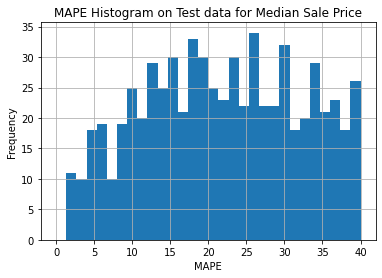

In [53]:
test_county_mape = plot_mape_dist(counterfactual_df_test, test_expected_df_sale, "predicted_median_sale_price", "median_sale_price")

In [54]:
counterfactual_df['period_begin'] = pd.to_datetime(counterfactual_df['period_begin'])
post_covid_expected_df_sale['period_begin'] = pd.to_datetime(post_covid_expected_df_sale['period_begin'])

C:\ProgramData\Anaconda3\envs\TML\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


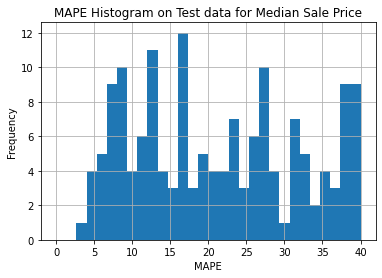

In [55]:
test_county_mape_post_covid = plot_mape_dist(counterfactual_df, post_covid_expected_df_sale, "predicted_median_sale_price", "median_sale_price")

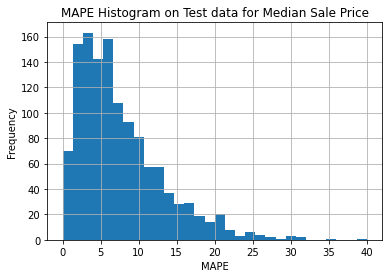

In [184]:
test_county_mape = plot_mape_dist(counterfactual_df_test, test_expected_df_sale, "predicted_median_sale_price", "median_sale_price")

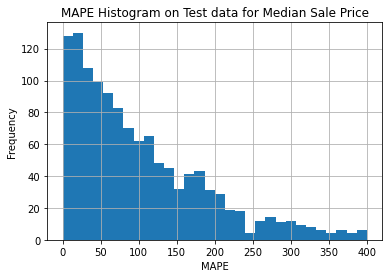

In [154]:
test_county_mape = plot_mape_dist(counterfactual_df_test, test_expected_df_sale, "predicted_median_sale_price", "median_sale_price")

In [56]:
result = pd.merge(counterfactual_df_test, test_expected_df_sale, on=['county_name', 'state_code', 'period_begin'])
result.to_csv(f"{data_folder}sale_test_pred_comparison.csv")
test_county_mape.to_csv(f"{data_folder}sale_test_pred_comparison_MAPE.csv")

In [57]:
result_pc = pd.merge(counterfactual_df, post_covid_expected_df_sale, on=['county_name', 'state_code', 'period_begin'])
result_pc.to_csv(f"{data_folder}sale_post_covid_pred_comparison.csv")
test_county_mape_post_covid.to_csv(f"{data_folder}sale_post_covid_pred_comparison_MAPE.csv")